# The Jaynes-Cummings Model

Heavily adapted from this [notebook](https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/time-evolution/004_rabi-oscillations.ipynb)


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from cycler import cycler
from qutip import basis, destroy, mesolve, qeye, sigmaz, tensor

%matplotlib inline

# set some plot defaults
mpl.rcParams['axes.grid'] = True
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# stole colors from scQubits
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#016E82",
        "#333795",
        "#2E5EAC",
        "#4498D3",
        "#CD85B9",
        "#45C3D1",
        "#AA1D3F",
        "#F47752",
        "#19B35A",
        "#EDE83B",
        "#ABD379",
        "#F9E6BE",
    ]
)

# Helper Methods

## Defining the Jaynes-Cummings Hamiltonian

Recall from class that the Jaynes-Cummings Hamiltonian is given by ($\hbar = 1$):

$H_{JC} = \omega_c (a^{\dag} a + \frac{1}{2}) + \frac{1}{2} \omega_q \sigma_z + g (a^{\dag} + a)(\sigma_- + \sigma_+)$.

When we make the rotating-wave approximation (RWA), this simplifies to

$H_{JC} = \omega_c (a^{\dag} a + \frac{1}{2}) + \frac{1}{2} \omega_q \sigma_z + g (a^{\dag} \sigma_- + a \sigma_+)$.

<br>
<br>
To model dissipation in this system, we use collapse operators and follow the Lindblad master equation (recall from `qutip_intro.ipynb`):

$\dot\rho (t) = -\frac{i}{\hbar} \left[H(t), \rho(t) \right] + \sum\limits_{n} \frac{1}{2} \left[2 C_n\rho(t)C_n^{\dagger} - \rho(t)C_n^{\dagger}C_n - C_n^{\dagger}C_n\rho(t)  \right]$

There are two operators for the cavity (creation + annihilation at different enhanced rates) and one for qubit decay:

$C_1 = \sqrt{\kappa (\langle n \rangle + 1)} a$

$C_2 = \sqrt{\kappa \langle n \rangle} a^{\dag}$

$C_3 = \sqrt{\gamma} \sigma_-$

In [2]:
def H_JC(wc, wq, g, kappa, gamma, N=15, n_th_a=0, use_rwa=True):
    """Constructs the Jaynes-Cummings Hamiltonian and collapse operators.

    Args:
        wc (float): Cavity frequency.
        wq (float): Qubit frequency.
        g (float): Coupling strength.
        kappa (float): Cavity dissipation rate.
        gamma (float): Qubit dissipation rate.
        N (int, optional): Number of cavity Fock states. Defaults to 15.
        n_th_a (float, optional): Temperature in frequency units. Defaults to 0.
        use_rwa (bool, optional): Whether to use the Rotating Wave Approximation (RWA). Defaults to True.

    Returns:
        tuple: Hamiltonian (Qobj) and list of collapse operators (list of Qobj).
    """
    a = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2).dag())
    sz = tensor(qeye(N), sigmaz())
    
    if use_rwa:
        H = wc * a.dag() * a + wq / 2 * sz + g * (a.dag() * sm + a * sm.dag())
    else:
        H = wc * a.dag() * a + wq / 2 * sz + g * (a.dag() + a) * (sm + sm.dag())
    
    # Collapse operators
    c_op_list = []

    # Photon annihilation
    rate = kappa * (1 + n_th_a)
    c_op_list.append(np.sqrt(rate) * a)

    # Photon creation
    rate = kappa * n_th_a
    c_op_list.append(np.sqrt(rate) * a.dag())

    # Qubit annihilation
    rate = gamma
    c_op_list.append(np.sqrt(rate) * sm)

    return H, c_op_list

# Vacuum Rabi oscillations in the Jaynes-Cummings model

## No decay

In [3]:
N = 15  # number of cavity Fock states
wc = 5.0 * 2 * np.pi  # cavity frequency
wq = 5.0 * 2 * np.pi  # qubit frequency
g = 0.02 * 2 * np.pi  # coupling strength
kappa = 0.0  # cavity dissipation rate
gamma = 0.0  # qubit dissipation rate
n_th_a = 0.0  # temperature in frequency units

H, c_op_list = H_JC(wc, wq, g, kappa, gamma, N, n_th_a)

In [4]:
psi0 = tensor(basis(N, 0), basis(2, 0))
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())

tlist = np.linspace(0, 20 / g, 600)

output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a, sm.dag() * sm])

/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


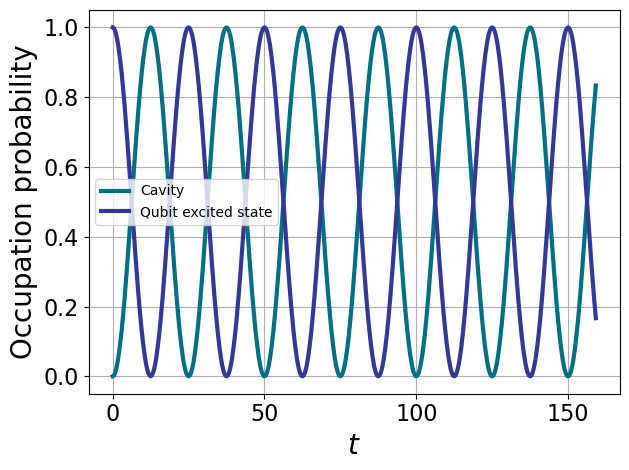

In [5]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()

## Add in decay

In [6]:
N = 15  # number of cavity Fock states
wc = 5.0 * 2 * np.pi  # cavity frequency
wq = 5.0 * 2 * np.pi  # qubit frequency
g = 0.02 * 2 * np.pi  # coupling strength
kappa = 0.008  # cavity dissipation rate
gamma = 0.001  # qubit dissipation rate
n_th_a = 0.0  # temperature in frequency units

H_res, c_op_list_res = H_JC(wc, wq, g, kappa, gamma, N, n_th_a)


What is the cooperativity?

In [7]:
g ** 2 / (kappa * gamma)

1973.9208802178719

Time evolution

In [8]:
psi0 = tensor(basis(N, 0), basis(2, 0))
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())

tlist = np.linspace(0, 100 / g, 600)

output_res = mesolve(H_res, psi0, tlist, c_op_list_res, [a.dag() * a, sm.dag() * sm])

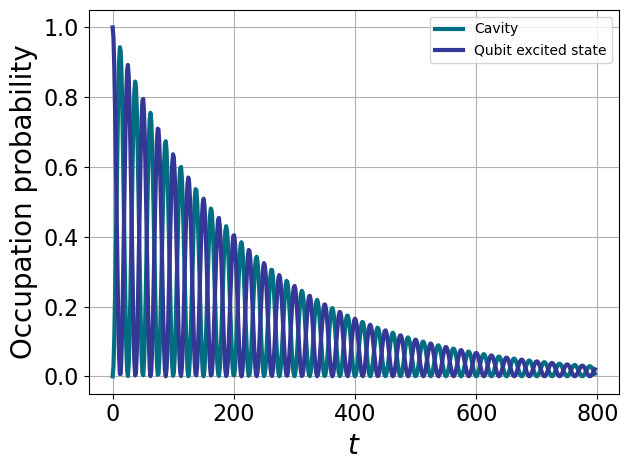

In [9]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output_res.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()

now let's add in the analytical decay functions

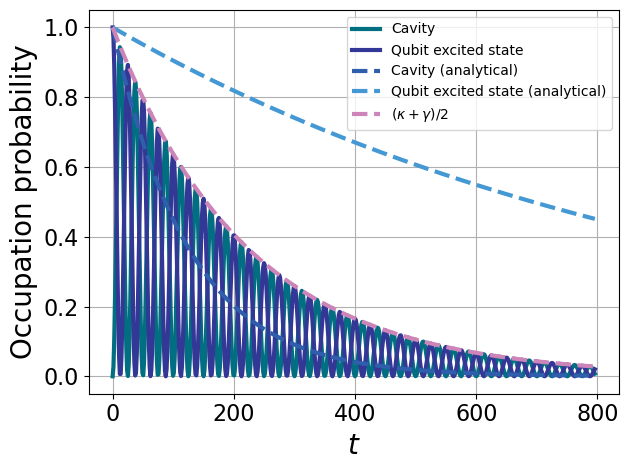

In [10]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output_res.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.plot(
    tlist,
    np.exp(-kappa * tlist),
    label="Cavity (analytical)",
    linestyle="--",
)
ax.plot(
    tlist,
    np.exp(-gamma * tlist),
    label="Qubit excited state (analytical)",
    linestyle="--",
)
ax.plot(
    tlist,
    np.exp(-(kappa + gamma) / 2 * tlist),
    label=r"$(\kappa + \gamma) / 2$",
    linestyle="--",
)
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()

### Non-zero temperature

In [ ]:
N = 15  # number of cavity Fock states
wc = 5.0 * 2 * np.pi  # cavity frequency
wq = 5.0 * 2 * np.pi  # qubit frequency
g = 0.02 * 2 * np.pi  # coupling strength
kappa = 0.008  # cavity dissipation rate
gamma = 0.001  # qubit dissipation rate
n_th_a = 1.0  # temperature in frequency units

H_temp, c_op_list_temp = H_JC(wc, wq, g, kappa, gamma, N, n_th_a)

psi0 = tensor(basis(N, 0), basis(2, 0))
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())

tlist = np.linspace(0, 20 / g, 300)

# evolve system
output_temp = mesolve(H_temp, psi0, tlist, c_op_list_temp, [a.dag() * a, sm.dag() * sm])

In [ ]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output_temp.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()

## No RWA

In [ ]:
N = 15  # number of cavity Fock states
wc = 5.0 * 2 * np.pi  # cavity frequency
wq = 5.0 * 2 * np.pi  # qubit frequency
g = 4.0 * 2 * np.pi  # coupling strength, make on order of Qubit and cavity frequencies
kappa = 0.08  # cavity dissipation rate
gamma = 0.01  # qubit dissipation rate
n_th_a = 0.0  # temperature in frequency units
use_rwa = False  # don't assume RWA

H_no_rwa, c_op_list_no_rwa = H_JC(wc, wq, g, kappa, gamma, N, n_th_a, use_rwa)

psi0 = tensor(basis(N, 0), basis(2, 0))
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())

tlist = np.linspace(0, 50 / g, 300)

# evolve system
output_no_rwa = mesolve(H_no_rwa, psi0, tlist, c_op_list_no_rwa, [a.dag() * a, sm.dag() * sm])

In [ ]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output_no_rwa.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()

## Detuned regime

In [ ]:
# redfine some params - now the systems are no longer resonant
N = 15  # number of cavity Fock states
wc = 5.0 * 2 * np.pi  # cavity frequency
wq = 4.8 * 2 * np.pi  # qubit frequency
g = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.002  # cavity dissipation rate
gamma = 0.0005  # qubit dissipation rate
n_th_a = 0.0  # temperature in frequency units

# back with RWA
H_detune, c_op_list_detune = H_JC(wc, wq, g, kappa, gamma, N, n_th_a)

psi0 = tensor(basis(N, 0), basis(2, 0))
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())

tlist = np.linspace(0, 80 / g, 600)

# evolve system
output_detune = mesolve(H_detune, psi0, tlist, c_op_list_detune, [a.dag() * a, sm.dag() * sm])

In [ ]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output_detune.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1)
labels = [r"Cavity", r"Qubit excited state"]
for i, evals in enumerate(output_detune.expect):
    ax.plot(
        tlist,
        evals,
        label=labels[i],
    )
ax.plot(
    tlist,
    0.2 * np.exp(-kappa * tlist),
    label="Cavity (analytical)",
    linestyle="--",
)
ax.plot(
    tlist,
    np.exp(-gamma * tlist),
    label="Qubit excited state (analytical)",
    linestyle="--",
)
ax.plot(
    tlist,
    np.exp(-(kappa + gamma) / 2 * tlist),
    label=r"$(\kappa + \gamma) / 2$",
    linestyle="--",
)
ax.legend()
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel("Occupation probability", fontsize=20)
plt.tight_layout()